# Continuous Control
---

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from agent.agent import Agent
import torch
import time

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
agent = Agent(state_size, action_size, num_agents=num_agents,seed=0)

agent using cuda:0 device


In [6]:
def ddpg(n_episodes=500):  
    scores_deque = deque(maxlen=100)
    scores_avg = [] # initialize the score (for each agent)
    moving_averages = []
    max_score = 0
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment  
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)
        
        agent.reset()
        start_time = time.time()
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                       # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        
        score = np.mean(scores)
        scores_deque.append(score)
        scores_avg.append(score)
        moving_averages.append(np.mean(scores_deque))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f} \tTime: {:.2f}'.format(i_episode, np.mean(scores_deque), np.mean(scores), time.time()-start_time), end="")
        if np.mean(scores_deque)>max_score:
            max_score = np.mean(scores_deque)
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth'.format(i_episode))
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth'.format(i_episode))
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} \tMax score: {:.2f} \tEpsilon: {:.2f} \tTime: {:.2f}/per episode'.format(i_episode, np.mean(scores_deque), np.max(scores_deque), agent.epsilon, time.time()-start_time))   
    return scores_avg, moving_averages

In [7]:
scores, moving_averages = ddpg()

Episode 10	Average Score: 0.80 	Max score: 1.14 	Epsilon: 0.99 	Time: 10.60/per episode
Episode 20	Average Score: 1.11 	Max score: 2.16 	Epsilon: 0.99 	Time: 16.29/per episode
Episode 30	Average Score: 1.60 	Max score: 3.01 	Epsilon: 0.98 	Time: 16.10/per episode
Episode 40	Average Score: 2.12 	Max score: 6.15 	Epsilon: 0.98 	Time: 22.90/per episode
Episode 50	Average Score: 4.02 	Max score: 17.07 	Epsilon: 0.97 	Time: 17.25/per episode
Episode 60	Average Score: 7.41 	Max score: 29.03 	Epsilon: 0.97 	Time: 20.44/per episode
Episode 70	Average Score: 11.06 	Max score: 36.61 	Epsilon: 0.96 	Time: 18.57/per episode
Episode 80	Average Score: 14.39 	Max score: 38.71 	Epsilon: 0.96 	Time: 23.20/per episode
Episode 90	Average Score: 17.07 	Max score: 38.84 	Epsilon: 0.95 	Time: 26.78/per episode
Episode 100	Average Score: 19.20 	Max score: 39.03 	Epsilon: 0.95 	Time: 17.82/per episode
Episode 110	Average Score: 22.91 	Max score: 39.05 	Epsilon: 0.94 	Time: 18.14/per episode
Episode 120	Averag

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
ax.plot([0,500],[30,30], color='r', linestyle='--', linewidth=0.6)
ax.set_xlim(0, 500)
plt.ylabel('Avg. Score over all agents')
plt.xlabel('Episode #')
# plt.show()
plt.tight_layout()
plt.savefig('scores.eps')

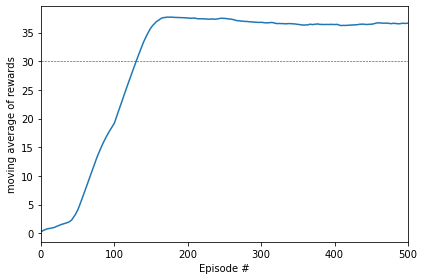

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(moving_averages)+1), moving_averages)
ax.plot([0,500],[30,30], color='r', linestyle='--', linewidth=0.6)
ax.set_xlim(0, 500)
plt.ylabel('moving average of rewards')
plt.xlabel('Episode #')
# plt.show()
plt.tight_layout()
plt.savefig('moving_average.eps')

## Watch trained agent

In [ ]:
agent.actor_local.load_state_dict(torch.load('actor.pth'))
agent.critic_local.load_state_dict(torch.load('critic.pth'))

In [ ]:
def watch():      
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment  
    states = env_info.vector_observations                  # get the current state (for each agent)
    while True:
        actions = agent.act(states, add_noise=False)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                       # see if episode finished           
        states = next_states
        if np.any(dones):
            break  

In [ ]:
watch()

In [ ]:
env.close()